In [1]:

import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy import stats

import pickle



from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from spektral.layers import ECCConv, GlobalAvgPool, MessagePassing, XENetConv, GlobalAttentionPool, GlobalMaxPool, GlobalSumPool,GlobalAttnSumPool

plt.style.use('ggplot')
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 



2021-12-07 14:39:16.377861: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:



sys.path.append('..')
from simulations import zonal_gnn

from sobol_seq import i4_sobol_generate


INPUT_DIM = 2
N_POINTS = 100


REP = 1.0
VA = 1.5*pi

params_max = np.array([25.0,25.0])
sobel_points = i4_sobol_generate(INPUT_DIM,N_POINTS)
param_values = np.zeros_like(sobel_points)


param_values[:,0]=REP + sobel_points[:,0]*(params_max[0]-REP)
param_values[:,1]=REP + sobel_points[:,1]*(params_max[1]-REP)



L= 200
N= 100 
repeat = 10
discard = 100
timesteps = 100
save_interval=10 
dt=0.1 


sim = zonal_gnn.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval,save_micro=True, disable_progress=True)
    

def evaluate_zonal_model(X):
    sim.run_sim(REP, X[0], X[1], VA)
    return

for i in tqdm(range(param_values.shape[0])):
    evaluate_zonal_model(param_values[i])
                    


  0%|                                                   | 0/100 [00:00<?, ?it/s]2021-12-07 14:39:18.273843: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-07 14:39:18.274368: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-07 14:39:18.311808: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-07 14:39:18.311830: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (office-pc): /proc/driver/nvidia/version does not exist
2021-12-07 14:39:18.312129: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable the

In [3]:


#************************************
#************************************
#********DATA LOADER*****************
#************************************
#************************************
#************************************

train_dir = 'train_datasets/'
valid_dir = 'valid_datasets/'

BATCH_SIZE=64
EPOCHS=200

all_file_list = [train_dir + filename for filename in os.listdir(train_dir)]

dataset_size = sum(1 for _ in tf.data.TFRecordDataset(all_file_list[0]))*len(all_file_list)//BATCH_SIZE


feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'timestep': tf.io.FixedLenFeature([], tf.int64),
                        'parameter_vector': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string),
                        'acc': tf.io.FixedLenFeature([], tf.string)}

def _parse_record(x):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'timestep': x['timestep'],
                'parameter_vector': x['parameter_vector'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32),
                'acc': tf.io.parse_tensor(x['acc'],out_type=tf.float32)}
    return output

def _parse_keras(x):
    pos = x['pos']
    #pos.set_shape((None,2))
    vel = x['vel']
    #vel.set_shape((None,2))
    acc = x['acc']
    #acc.set_shape((None,2))
    
    target = x['parameter_vector']
    output = ((pos,vel,acc),target)
    #target.set_shape((4))
    #output = pos,vel,acc
    return output


    
    
    

train_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([train_dir + filename for filename in os.listdir(train_dir)]))

parsed_train_dataset = train_dataset.map(_parse_record)
parsed_train_dataset = parsed_train_dataset.map(_parse_tensor)
parsed_train_dataset = parsed_train_dataset.map(_parse_keras)


parsed_train_dataset = parsed_train_dataset.shuffle(10000, reshuffle_each_iteration=True)
#parsed_train_dataset = parsed_train_dataset.repeat(EPOCHS)
parsed_train_dataset = parsed_train_dataset.batch(BATCH_SIZE, drop_remainder=True)


valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

parsed_valid_dataset = valid_dataset.map(_parse_record)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_tensor)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_keras)
parsed_valid_dataset = parsed_valid_dataset.batch(BATCH_SIZE, drop_remainder=True)



In [5]:
DOMAIN_SIZE=200.
MAX_RADIUS=25.

max_params = np.array([25.0,25.0],dtype=np.float32)

def process_graph(X, V, A):
    #inputs, targets = x
    
    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*DOMAIN_SIZE, dx-DOMAIN_SIZE, dx)
    dx = tf.where(dx<-0.5*DOMAIN_SIZE, dx+DOMAIN_SIZE, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*DOMAIN_SIZE, dy-DOMAIN_SIZE, dy)
    dy = tf.where(dy<-0.5*DOMAIN_SIZE, dy+DOMAIN_SIZE, dy)

    Vx = tf.expand_dims(V[...,0],-1)
    dvx = -Vx + tf.linalg.matrix_transpose(Vx)

    Vy = tf.expand_dims(V[...,1],-1)
    dvy = -Vy + tf.linalg.matrix_transpose(Vy)
    
    dvnorm = tf.math.sqrt(dvx**2+dvy**2)
    dvx = tf.math.divide_no_nan(dvx,dvnorm)
    dvy = tf.math.divide_no_nan(dvy,dvnorm)

    angles = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - angles

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    adj_matrix = tf.where(dist<MAX_RADIUS, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)
    output_ie = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_edge)


    senders =tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

    output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
    edge_distance = tf.expand_dims(tf.gather_nd(dist/MAX_RADIUS, sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
    edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

    edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
    edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


    output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)

    node_velocities = tf.reshape(V,(-1,2))
    node_accelerations = tf.reshape(A,(-1,2))

    output_x = tf.concat([node_velocities,node_accelerations],axis=-1)

    return (output_x, output_a, output_e, output_i,output_ie)


In [28]:

SPEED = 3.0
ETA = 0.9
NOISE = 0.1

Rr = 1.0
va = 1.5*pi
#        Ro, Ra


tf_max_params = tf.constant(max_params)
scale_factor = tf.constant(1.) # smoothing parameter for zonal model thresholds

@tf.function
def predicted_move(params, X, V):
    
    Ro, Ra = tf.split(params,2,axis=-1)
    Ro = tf.expand_dims(Ro,-1) # need to expand to be (Bx1x1) so it can broadcast with dist which is (BxNxN)
    Ra = tf.expand_dims(Ra,-1)
    
    angles = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    cos_A = tf.math.cos(angles)
    sin_A = tf.math.sin(angles)


    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*DOMAIN_SIZE, dx-DOMAIN_SIZE, dx)
    dx = tf.where(dx<-0.5*DOMAIN_SIZE, dx+DOMAIN_SIZE, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*DOMAIN_SIZE, dy-DOMAIN_SIZE, dy)
    dy = tf.where(dy<-0.5*DOMAIN_SIZE, dy+DOMAIN_SIZE, dy)


    angle_to_neigh = tf.math.atan2(dy, dx)
    cos_N = tf.math.cos(angle_to_neigh)
    sin_N = tf.math.sin(angle_to_neigh)
    rel_angle_to_neigh = angle_to_neigh - angles
    rel_angle_to_neigh = tf.math.atan2(tf.math.sin(rel_angle_to_neigh), tf.math.cos(rel_angle_to_neigh))

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    # repulsion 
    rep_x = -dx*tf.math.sigmoid(scale_factor*(Rr-dist))
    rep_x = rep_x*tf.math.sigmoid(scale_factor*(0.5*va - tf.math.abs(rel_angle_to_neigh)))
    rep_x = tf.math.divide_no_nan(rep_x,tf.math.square(dist))
    rep_x = tf.reduce_sum(rep_x,axis=1)
    
    rep_y = -dy*tf.math.sigmoid(scale_factor*(Rr-dist))
    rep_y = rep_y*tf.math.sigmoid(scale_factor*(0.5*va - tf.math.abs(rel_angle_to_neigh)))
    rep_y = tf.math.divide_no_nan(rep_y,tf.math.square(dist))
    rep_y = tf.reduce_sum(rep_y,axis=1)

#     rep_norm = tf.math.sqrt(rep_x**2+rep_y**2)
#     rep_x = tf.math.divide_no_nan(rep_x,rep_norm)
#     rep_y = tf.math.divide_no_nan(rep_y,rep_norm)

    # alignment 
    #align_x = tf.where(dist<=Ro, cos_A, tf.zeros_like(cos_A))
    #align_x = tf.where(dist>Rr, align_x, tf.zeros_like(align_x))
    #align_x = cos_A*Ro
    align_x = cos_A*tf.math.sigmoid(scale_factor*(Ro-dist))
    #return align_x
    align_x = align_x*tf.math.sigmoid(scale_factor*(0.5*va - tf.math.abs(rel_angle_to_neigh)))

    #align_x = tf.where(rel_angle_to_neigh<0.5*va, align_x, tf.zeros_like(align_x))
    #align_x = tf.where(rel_angle_to_neigh>-0.5*va, align_x, tf.zeros_like(align_x))
    align_x = tf.reduce_sum(align_x,axis=1)

    #align_y = tf.where(dist<=Ro, sin_A, tf.zeros_like(sin_A))
    align_y = sin_A*tf.math.sigmoid(scale_factor*(Ro-dist))
    align_y = align_y*tf.math.sigmoid(scale_factor*(0.5*va - tf.math.abs(rel_angle_to_neigh)))

    #align_y = tf.where(dist>Rr, align_y, tf.zeros_like(align_y))

    #align_y = tf.where(rel_angle_to_neigh<0.5*va, align_y, tf.zeros_like(align_y))
    #align_y = tf.where(rel_angle_to_neigh>-0.5*va, align_y, tf.zeros_like(align_y))
    align_y = tf.reduce_sum(align_y,axis=1)

    al_norm = tf.math.sqrt(align_x**2+align_y**2)
    align_x = tf.math.divide_no_nan(align_x,al_norm)
    align_y = tf.math.divide_no_nan(align_y,al_norm)

    # attractive interactions
    #attr_x = tf.where(dist<=Ra, dx, tf.zeros_like(dx))
    attr_x = dx*tf.math.sigmoid(scale_factor*(Ra-dist))
    attr_x = attr_x*tf.math.sigmoid(scale_factor*(0.5*va - tf.math.abs(rel_angle_to_neigh)))

    #attr_x = tf.where(dist>(Ro+Rr), attr_x, tf.zeros_like(attr_x))
    #attr_x = tf.where(rel_angle_to_neigh<0.5*va, attr_x, tf.zeros_like(attr_x))
    #attr_x = tf.where(rel_angle_to_neigh>-0.5*va, attr_x, tf.zeros_like(attr_x))
    attr_x = tf.reduce_sum(attr_x,axis=2)

    #attr_y = tf.where(dist<=Ra, dy, tf.zeros_like(dy))
    attr_y = dy*tf.math.sigmoid(scale_factor*(Ra-dist))
    attr_y = attr_y*tf.math.sigmoid(scale_factor*(0.5*va - tf.math.abs(rel_angle_to_neigh)))
    #attr_y = tf.where(dist>(Ro+Rr), attr_y, tf.zeros_like(attr_y))
    #attr_y = tf.where(rel_angle_to_neigh<0.5*va, attr_y, tf.zeros_like(attr_y))
    #attr_y = tf.where(rel_angle_to_neigh>-0.5*va, attr_y, tf.zeros_like(attr_y))
    attr_y = tf.reduce_sum(attr_y,axis=2)

    at_norm = tf.math.sqrt(attr_x**2+attr_y**2)
    attr_x = tf.math.divide_no_nan(attr_x,at_norm)
    attr_y = tf.math.divide_no_nan(attr_y,at_norm)

    # combine angles and convert to desired angle change
    # social_x =align_x + attr_x#tf.where(rep_norm>1e-6,rep_x, align_x + attr_x)
    # social_y =align_y + attr_y# tf.where(rep_norm>1e-6,rep_y, align_y + attr_y)
    
    social_x = rep_x + align_x + attr_x
    social_y = rep_y + align_y + attr_y
    social_norm = tf.math.sqrt(social_x**2+social_y**2)
    social_x = tf.math.divide_no_nan(social_x,social_norm)
    social_y = tf.math.divide_no_nan(social_y,social_norm)

    #d_angle = tf.math.atan2(social_y,social_x)
    #d_angle = social_y + social_x

    social_x = tf.expand_dims(social_x,-1)
    social_y = tf.expand_dims(social_y,-1)

    nvx = (1-ETA)*social_x + ETA*cos_A
    nvy = (1-ETA)*social_y + ETA*sin_A
    
    v_norm = tf.math.sqrt(nvx**2+nvy**2)
    nvx = tf.math.divide_no_nan(nvx,v_norm)
    nvy = tf.math.divide_no_nan(nvy,v_norm)

    #d_angle = tf.math.atan2((1-ETA)*tf.math.sin(d_angle) + ETA*sin_A, (1-ETA)*tf.math.cos(d_angle) + ETA*cos_A)

    # update velocity
    V = dt*SPEED*tf.concat([nvx,nvy],axis=-1)

#     d_angle = tf.math.atan2(social_y,social_x)
#     d_angle = tf.expand_dims(d_angle,-1)


#     d_angle = tf.math.atan2((1-ETA)*tf.math.sin(d_angle) + ETA*sin_A, (1-ETA)*tf.math.cos(d_angle) + ETA*cos_A)

# #     d_angle = d_angle - angles
# #     d_angle = tf.where(d_angle>pi, d_angle-2*pi, d_angle)
# #     d_angle = tf.where(d_angle<-pi, d_angle+2*pi, d_angle)


# #     # add perception noise
# #     #noise = tf.random.normal(shape=(self.B,self.N,1),mean=0,stddev=NOISE*(self.dt**0.5))
# #     #d_angle = d_angle + noise

# #     # restrict to maximum turning angle
# #     #d_angle = tf.where(tf.math.abs(d_angle)>eta*self.dt, tf.math.sign(d_angle)*eta*self.dt, d_angle)

# #     # rotate headings
# #     angles = angles + d_angle

#     # update velocity
#     V = dt*SPEED*tf.concat([tf.cos(d_angle),tf.sin(d_angle)],axis=-1)


    return V

# params = tf.Variable(([[1.0,1.0]]))
# with tf.GradientTape() as tape:
#     (X, V, A), target = batch
#     #graph_batch = process_graph(X,V,A)
#     #bottleneck = gnn_model(graph_batch)
#     #loss = tf.reduce_sum(bottleneck)

#     predicted_moves = predicted_move(params,X,V)
#     loss = tf.reduce_sum(predicted_moves)#tf.math.square(predicted_moves - A))

# gradients = tape.gradient(loss, params)#gnn_model.trainable_variables)

# gradients

In [29]:
# gradients

In [57]:
#************************************
#************************************
#********GNN MODEL*******************
#************************************
#************************************
#************************************

n_out = 2
n_feat_node=4
n_feat_edge=5

MLP_SIZE=4

X_in = Input(shape=(n_feat_node,))
A_in = Input(shape=(None,), sparse=True)
E_in = Input(shape=(n_feat_edge,))
I_in = Input(shape=(), dtype=tf.int64)
IE_in = Input(shape=(), dtype=tf.int64)

X = Dense(MLP_SIZE, activation="tanh")(X_in)
E = Dense(MLP_SIZE, activation="tanh")(E_in)

X, E = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
X, E = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="tanh", edge_activation="tanh")([X, A_in, E])

X = Dense(MLP_SIZE, activation="tanh",use_bias=False)(X)
E = Dense(MLP_SIZE, activation="tanh",use_bias=False)(E)

X = Concatenate()([X, X_in])
E = Concatenate()([E, E_in])

Xs = GlobalAttnSumPool()([X, I_in])
Xm = GlobalMaxPool()([X, I_in])
Xa = GlobalAvgPool()([X, I_in])

Es = GlobalAttnSumPool()([E, IE_in])
Em = GlobalMaxPool()([E, IE_in])
Ea = GlobalAvgPool()([E, IE_in])

X = Concatenate()([Xs,Xm,Xa, Es,Em,Ea])
X = Dense(MLP_SIZE, activation="tanh",use_bias=False)(X)
output = Dense(n_out, activation="relu",use_bias=False)(X)#,use_bias=False)(X)

gnn_model = Model(inputs=[X_in, A_in, E_in, I_in, IE_in], outputs=output)


In [43]:
# with tf.GradientTape() as tape:
    
#     predicted_moves = predicted_move(params[None,0],X[None,0],V[None,0])
# # #     loss = tf.reduce_sum(predicted_moves)#tf.math.square(predicted_moves - A))

# # # 

# #         graph_batch = process_graph(X,V,A)
# #         bottleneck = gnn_model(graph_batch)
# #         predicted_moves = predicted_move(bottleneck,X,V)

# #         #loss = tf.reduce_sum(tf.reduce_mean(tf.math.square(predicted_moves - A),axis=[1,2]))
# #         #print(gnn_model()
#     loss = tf.reduce_sum(tf.math.square(predicted_moves - A))


# gradients = tape.gradient(loss, params[None,0])#,unconnected_gradients=tf.UnconnectedGradients.ZERO)#gnn_model.trainable_variables)
# gradients

In [44]:
# with tf.GradientTape() as tape:
    
#     #predicted_moves = predicted_move(params,X,V)
# # #     loss = tf.reduce_sum(predicted_moves)#tf.math.square(predicted_moves - A))

# # # 

#     graph_batch = process_graph(X,V,A)
#     bottleneck = gnn_model(graph_batch)
#     predicted_moves = predicted_move(bottleneck,X,V)

# #         #loss = tf.reduce_sum(tf.reduce_mean(tf.math.square(predicted_moves - A),axis=[1,2]))
# #         #print(gnn_model()
#     loss = tf.reduce_sum(tf.math.square(predicted_moves - A))


# gradients = tape.gradient(loss, bottleneck)#,unconnected_gradients=tf.UnconnectedGradients.ZERO)#gnn_model.trainable_variables)
# gradients

In [45]:
# params = tf.Variable(bottleneck)


In [46]:
# for batch in parsed_train_dataset:
#     (X, V, A), target = batch
#     #break
    

#     with tf.GradientTape() as tape:
    
# #     #graph_batch = process_graph(X,V,A)
# #     #bottleneck = gnn_model(graph_batch)
# #     #loss = tf.reduce_sum(bottleneck)

# #     predicted_moves = predicted_move(params,X,V)
# #     loss = tf.reduce_sum(predicted_moves)#tf.math.square(predicted_moves - A))

# # 

#         graph_batch = process_graph(X,V,A)
#         #bottleneck = target[:,1:3]/max_params
#         bottleneck = gnn_model(graph_batch)
#         predicted_moves = predicted_move(bottleneck,X,V)

#         #loss = tf.reduce_sum(tf.reduce_mean(tf.math.square(predicted_moves - A),axis=[1,2]))
#         #print(gnn_model()
#         loss = tf.reduce_sum(tf.math.square(predicted_moves - A))

#     break
# gradients = tape.gradient(loss, gnn_model.trainable_variables)
# #gradients

In [47]:
# test_target = target[:,1:3]/max_params
# predicted_moves = predicted_move(test_target,X,V)

In [48]:
# tf.reduce_sum(tf.math.square(predicted_moves - A))

In [49]:
#predicted_moves[33]

In [50]:
#predicted_moves
#gradients[33]

In [51]:
#gradients

In [61]:
learning_rate = 1e-1# Learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#@tf.function()#input_signature=[[tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32)],tf.TensorSpec(shape=(None,4), dtype=tf.float32)], experimental_relax_shapes=True)
def train_step(inputs):
    (X, V, A), target = inputs
    graph_batch = process_graph(X,V,A)
    with tf.GradientTape() as tape:
        bottleneck = gnn_model(graph_batch)
        predicted_moves = predicted_move(bottleneck,X,V)
        loss = tf.reduce_sum(tf.math.square(predicted_moves - A))
        
    gradients = tape.gradient(loss, gnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gnn_model.trainable_variables))
    return loss



In [62]:
epochs = 1000
losses = []
validlosses = []
for epoch in range(epochs):
    print('training epoch ' + str(epoch)+ '...')
    pbar = tqdm(parsed_train_dataset)
    epoch_loss = 0
    c = 0 
    # Iterate over the batches of the dataset.
    for databatch in  pbar:
#         if train_step.experimental_get_tracing_count()==0:
#             (X, V, A), target = inputs
#             graph_batch = process_graph(X,V,A)
#             bottleneck = gnn_model(graph_batch)
            
        loss_value = train_step(databatch).numpy()
        epoch_loss+= loss_value
        c+=1
        pbar.set_description("Loss %f" % (epoch_loss/c))
    losses.append(epoch_loss/c)

training epoch 0...


Loss 2.132520: : 125it [00:22,  5.56it/s]


training epoch 1...


Loss 2.140745: : 125it [00:22,  5.58it/s]


training epoch 2...


Loss 2.127379: : 125it [00:22,  5.58it/s]


training epoch 3...


Loss 2.129244: : 121it [00:21,  5.54it/s]


KeyboardInterrupt: 

31it [00:01, 18.22it/s]


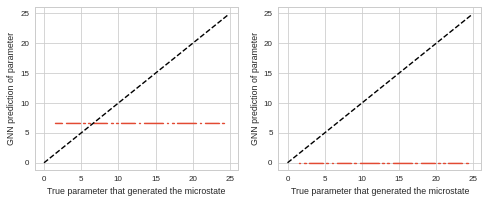

In [63]:

    
    
pred_list = []
true_values = []
for databatch in tqdm(parsed_valid_dataset):
    (X, V, A), target = databatch
    graph_batch = process_graph(X,V,A)
    
    true_values.append(target[:,1:3].numpy())#/max_params)


    predictions = gnn_model(graph_batch)
    pred_list.append(np.squeeze(predictions.numpy()))





fig, axs = plt.subplots(1,2, figsize=(8, 3), facecolor='w', edgecolor='k')  

axs = axs.ravel()
for pred_i in range(2):

    pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,pred_i] for tt in true_values]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(0,true_vals.max(),10)
    axs[pred_i].plot(xx,xx,c='k',ls='--')

    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter that generated the microstate')



plt.savefig('gnn_trained.png',dpi=300)

In [18]:
pred_list

[array([[0.41722658, 0.83440334],
        [0.44940123, 0.84817016],
        [0.42418656, 0.8316014 ],
        [0.4528509 , 0.84758806],
        [0.43872744, 0.8247855 ],
        [0.46130618, 0.84630394],
        [0.44260225, 0.8230382 ],
        [0.45521414, 0.8517004 ],
        [0.43030155, 0.8253479 ],
        [0.47334364, 0.8463953 ],
        [0.42578578, 0.82173383],
        [0.45826113, 0.83991635],
        [0.4205596 , 0.81235504],
        [0.46294513, 0.8457937 ],
        [0.41108757, 0.8107995 ],
        [0.4793946 , 0.85604316],
        [0.41601497, 0.80410945],
        [0.46534717, 0.8582676 ],
        [0.4158034 , 0.8002806 ],
        [0.4719969 , 0.8525405 ],
        [0.43908072, 0.8397187 ],
        [0.4721357 , 0.856843  ],
        [0.44331926, 0.8354823 ],
        [0.45741412, 0.8471774 ],
        [0.44083595, 0.8361821 ],
        [0.46182647, 0.84896016],
        [0.43284214, 0.84194636],
        [0.45648077, 0.8430822 ],
        [0.4501506 , 0.8430799 ],
        [0.464

In [ ]:


# @tf.function - ideally we'd like to decorate this with tf.function for faster code - but the connectivity utils is written using numpy so will need to be converted to tensorflow code
def train_step(x, y):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(x,y)
    grads = tape.gradient(loss_value, simulator.trainable_variables)
    optimizer.apply_gradients(zip(grads, simulator.trainable_variables))
    return loss_value

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(iter(ds)):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

In [ ]:


gnn_model.compile(optimizer=Adam(learning_rate), loss="mse")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='gnn/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                                            save_weights_only=True,
                                                            monitor='val_loss',
                                                            mode='max',
                                                            save_best_only=True)

stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    min_delta=0,
                                                    patience=2,
                                                    verbose=0,
                                                    mode="auto",
                                                    restore_best_weights=True)

gnn_model.fit(parsed_train_dataset, steps_per_epoch=dataset_size, epochs=EPOCHS, validation_data=parsed_valid_dataset, callbacks=[checkpoint_callback,stop_callback])

gnn_model.save('gnn/gnn_model')


#************************************
#************************************
#********SAVE FIGURE*****************
#************************************
#************************************
#************************************


    
    
pred_list = []
true_values = []
for databatch in tqdm(parsed_valid_dataset):

    target = databatch[1]
    true_values.append(target.numpy())


    predictions = gnn_model(databatch[0])
    pred_list.append(np.squeeze(predictions.numpy()))





fig, axs = plt.subplots(1,2, figsize=(8, 3), facecolor='w', edgecolor='k')  

axs = axs.ravel()
for pred_i in range(2):

    pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,pred_i] for tt in true_values]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(0,true_vals.max(),10)
    axs[pred_i].plot(xx,xx,c='k',ls='--')

    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter that generated the microstate')



plt.savefig('gnn_trained.png',dpi=300)
